## Model of Biosensor with hill function and resource competition for GFP transcription

Values of Constants from Bielefeld Team 


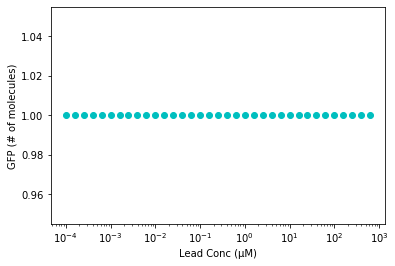

At translation rate  8.2e-05 nM/min, Range of Lead concentration which can be detected is  [[], 1] μM


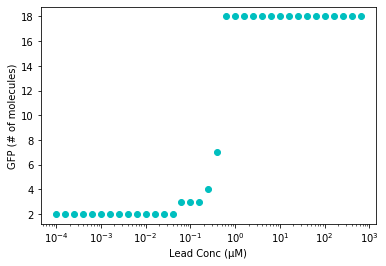

At translation rate  0.00082 nM/min, Range of Lead concentration which can be detected is  [0.25118864315095796, 0.630957344480193] μM


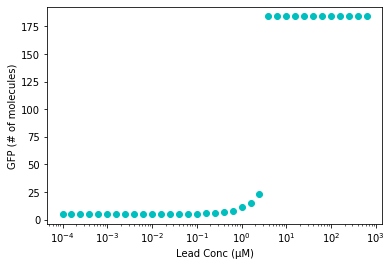

At translation rate  0.008199999999999999 nM/min, Range of Lead concentration which can be detected is  [1.584893192461114, 3.981071705534973] μM


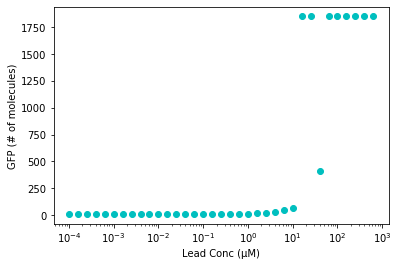

At translation rate  0.082 nM/min, Range of Lead concentration which can be detected is  [6.309573444801931, 63.0957344480193] μM


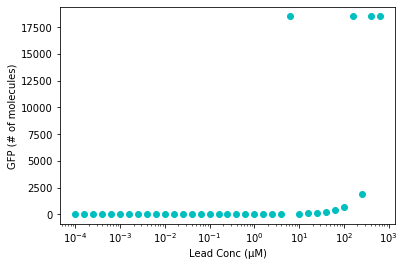

At translation rate  0.82 nM/min, Range of Lead concentration which can be detected is  [3.981071705534973, 398.1071705534969] μM


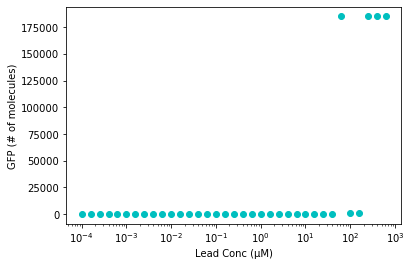

At translation rate  8.2 nM/min, Range of Lead concentration which can be detected is  [39.81071705534969, 251.1886431509582] μM


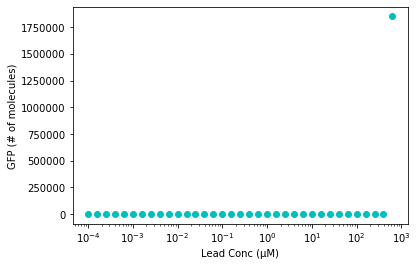

At translation rate  82.0 nM/min, Range of Lead concentration which can be detected is  [100.0, 398.1071705534969] μM


In [41]:
#Change the Lead concentration by 10^(0.2)~1.58, and check for at least linear increase in GFP Concentration

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
from scipy.integrate import solve_ivp
import math as mt

def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x / y

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
#vTL = 16.1       #Reporter translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244        #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

def model(t,z):
    
    #Initialize variables in a vector
    mR = z[0]         #repressor mRNA
    R = z[1]          #repressor monomer
    R2 = z[2]         #repressor dimer               #R2O - free operator of reporter gene
    Aout = z[3]
    A = z[4]          #analyte                       #R2A2 - repressor-operator complex
    O = z[5]          #inactive repressor
    mF = z[6]         #reporter mRNA
    Fin = z[7]        #inactive reporter
    F = z[8]          #reporter
    TLR = z[9]        #Translation resources
    TA = z[10]
    vTL = z[11]
    
    
    #ODEs  
    dmRdt = (vTX2*(GR**2)/((KTX2**2)+(GR**2))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (vTL*TLR*(mR**3)/((KTL2**3)+(mR**3)+(mF**3))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout)/2)      #Repressor dimer Conc               
    dAoutdt = -P*(Aout-A)
    dAdt = P*(Aout-A) - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout)/2)  #Analyte Conc
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**2)/((KTX1**2)+(O**2))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (vTL*TLR*(mF**3)/((KTL1**3)+(mF**3)+(mR**3))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    dTAdt = 0
    dvTLdt = 0
    
    return [dmRdt, dRdt, dR2dt, dAoutdt, dAdt, dOdt, dmFdt, dFindt, dFdt, dTLRdt, dTAdt, dvTLdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
TLR0 = 1520

O0 = 5
GR = O0

A0 = 0                 #Lead Concentration

TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<

t = np.linspace(0,300,100000)

AZ = []


def rang(v):
    
    GFP = []
    LD = []
    
    k = 0
    #For loop to find Range of detection (GFP Saturation)
    for i in range(-5,30):
        
        gfp = []
        Aout0 = 10**(i/5)            #10^(0.2) = 1.585, Expecting atleast a linear increase in fluoroscence
        TA = A0 + Aout0 + 2*R2A20
    
        z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]
    
        #y,az = odeint(model,z,t,args=(GR0,TO0,TA,v), full_output = True, atol = 1e-20, mxstep=5000000) #, hmax = ?? TRY Stuff....
        #AZ.append(az)
        
        ans = solve_ivp(fun=model, t_span=(0,300), y0=z, method = 'Radau') #t_eval = np.linspace(0,300,100000))

        gfp = ans['y'][8]       
        GFP.append(gfp[-1])
        LD.append(Aout0)
        
        l=0
        u=1
        
        k+=1

    
    n=0; m=0
    
    g = []; l = []
    G[:] = [mt.floor(A*0.6022) for A in GFP]
    L[:] = [A*1e-3 for A in LD]
    
    for n in range(1,k):
        #Check Lower Bound of Detection
        if safe_division(G[n],G[n-1]) > 1.5:
            #l.append(v)
            #l.append(GFP[i-1])
            #print(l)
            l = L[n-1]
            break

    for m in range(1,k-1):
        #Check Upper Bound of Detection
        if safe_division(G[m],G[m-1]) > 1.5:
            #u.append(v)
            #u.append(GFP[i+1])
            #print(u)
            u = L[m]
    
    r = [l, u]
    return r,G,L


#print("Rate of translation, [Range of lead that can be measured by the biosensor in μM]")

for i in range(-4,1):
    v = 0.82*10**i
    z,g,l = rang(v)
    r = [v, z]
    plt.plot(l, g, 'co')
    plt.xlabel("Lead Conc (μM)")
    plt.ylabel("GFP (# of molecules)")
    plt.xscale('log')
    plt.show()
    #R.append(r)
    print('At translation rate ',v,'nM/min, Range of Lead concentration which can be detected is ',z,'μM' )
    
    
#print([0.082, rang(0.082)])


## Signal degradation Rate

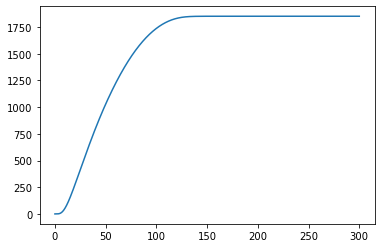

(12, 100000)
(12,)
[ 5.84832905e+01  7.14867856e-05  9.52358434e-10  7.72678304e+03
 -8.00058069e+02  4.99999810e+00  5.84832624e+01 -3.97854236e-10
  3.07329109e+03 -5.94633880e-11  1.00000000e+04  8.20000000e-02]
[58.483290490676204, 7.148678559526979e-05, 9.523584343112807e-10, 0, -800.0580693824231, 4.999998095283843, 58.48326244425632, -3.9785423583452615e-10, 3073.291085138361, -5.946338803703472e-11, 10000.0, 0.082]


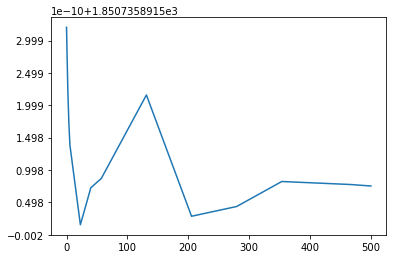

[1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703207, 1850.7358914703198, 1850.7358914703186, 1850.7358914703082, 1850.7358914702977, 1850.7358914702224, 1850.7358914701715, 1850.735891470138, 1850.735891470015, 1850.7358914700724, 1850.7358914700867, 1850.7358914702158, 1850.7358914700283, 1850.7358914700433, 1850.7358914700822, 1850.7358914700774, 1850.7358914700753]


In [83]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
from scipy.integrate import solve_ivp
import math as mt

def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x / y

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
#vTL = 16.1       #Reporter translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244        #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

def model(t,z):
    
    #Initialize variables in a vector
    mR = z[0]         #repressor mRNA
    R = z[1]          #repressor monomer
    R2 = z[2]         #repressor dimer               #R2O - free operator of reporter gene
    Aout = z[3]
    A = z[4]          #analyte                       #R2A2 - repressor-operator complex
    O = z[5]          #inactive repressor
    mF = z[6]         #reporter mRNA
    Fin = z[7]        #inactive reporter
    F = z[8]          #reporter
    TLR = z[9]        #Translation resources
    TA = z[10]
    vTL = z[11]
    
    
    #ODEs  
    dmRdt = (vTX2*(GR**2)/((KTX2**2)+(GR**2))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (vTL*TLR*(mR**3)/((KTL2**3)+(mR**3)+(mF**3))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout)/2)      #Repressor dimer Conc               
    dAoutdt = -P*(Aout-A)
    dAdt = P*(Aout-A) - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout)/2)  #Analyte Conc
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**2)/((KTX1**2)+(O**2))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (vTL*TLR*(mF**3)/((KTL1**3)+(mF**3)+(mR**3))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    dTAdt = 0
    dvTLdt = 0
    
    return [dmRdt, dRdt, dR2dt, dAoutdt, dAdt, dOdt, dmFdt, dFindt, dFdt, dTLRdt, dTAdt, dvTLdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
TLR0 = 1520

O0 = 5
GR = O0

A0 = 0                 #Lead Concentration
Aout0 = 1e4 

TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<
TA = A0 + Aout0 + 2*R2A20

v = 0.082

z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]

ans = solve_ivp(fun=model, t_span=(0,300), y0=z, method = 'BDF', t_eval = np.linspace(0,300,100000))

#print(np.shape(y()))

a = ans['y'][8]
g = []
g[:] = [A*0.6022 for A in a]

plt.plot(ans['t'], g)
plt.show()

Z = []; z1 = []
Z = ans['y']
print(np.shape(Z))

for i in range(0,12):
    if i != 3:
        z1.append(Z[i,99999])
    else:
        z1.append(0)
        
print(np.shape(z1))
print(Z[:,-1])
print(z1)

deg = solve_ivp(fun=model, t_span=(0,500), y0=z1, method = 'BDF')
a1 = deg['y'][8]
g1 = []
g1[:] = [A*0.6022 for A in a1]

plt.plot(deg['t'], g1)
plt.show()

print(g1)

## Model of Biosensor without hill function, using only Michelis-Menten Kinetics for GFP transcription

Values of Constants from :
Stamatakis, Michail; Mantzaris, Nikos V. (2009): Comparison of deterministic and stochastic models of the lac operon genetic network. In Biophysical journal 96 (3), pp. 887–906. DOI: 10.1016/j.bpj.2008.10.028.

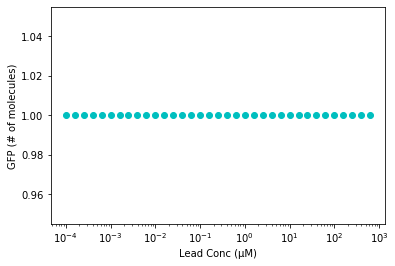

At translation rate  8.2e-05 nM/min, Range of Lead concentration which can be detected is  [[], 1] μM


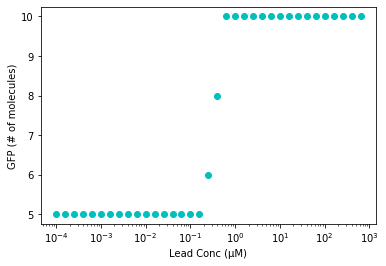

At translation rate  0.00082 nM/min, Range of Lead concentration which can be detected is  [[], 1] μM


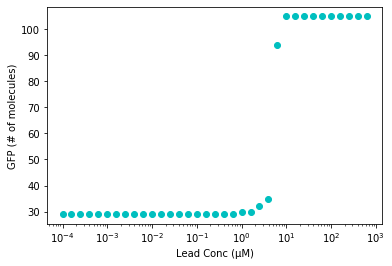

At translation rate  0.008199999999999999 nM/min, Range of Lead concentration which can be detected is  [3.981071705534973, 6.309573444801931] μM


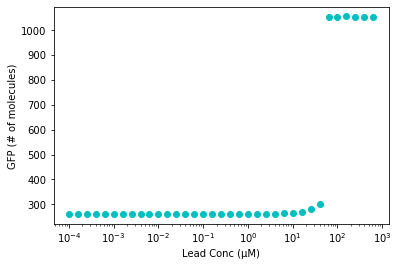

At translation rate  0.082 nM/min, Range of Lead concentration which can be detected is  [39.81071705534969, 63.0957344480193] μM


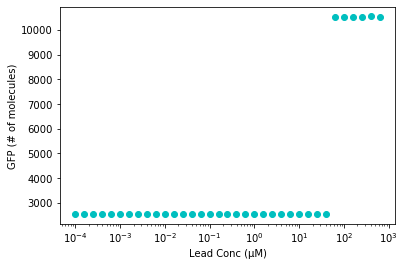

At translation rate  0.82 nM/min, Range of Lead concentration which can be detected is  [39.81071705534969, 63.0957344480193] μM


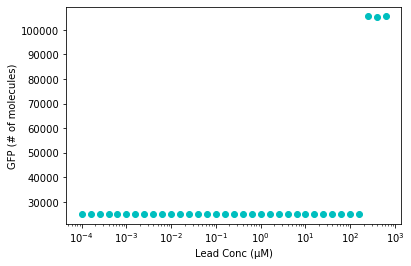

At translation rate  8.2 nM/min, Range of Lead concentration which can be detected is  [158.48931924611142, 251.1886431509582] μM


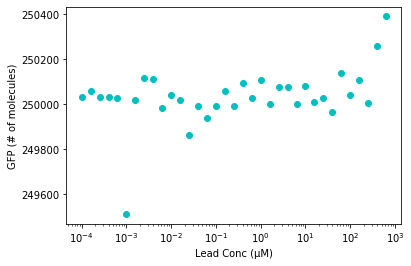

At translation rate  82.0 nM/min, Range of Lead concentration which can be detected is  [[], 1] μM


In [43]:

#print(ans)
#Change the Lead concentration by 10^(0.2)~1.58, and check for at least linear increase in GFP Concentration

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
from scipy.integrate import solve_ivp
import math as mt

def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x / y

#Initialize some constants
vTX = 0.23       #reporter transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.462    #reporter mRNA degradation rate constant
lam_m2 = 0.462     #repressor mRNA degradation rate constant
vTL = 15       #Reporter translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244        #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

def model1(t,z):
    
    #Initialize variables in a vector
    mR = z[0]         #repressor mRNA
    R = z[1]          #repressor monomer
    R2 = z[2]         #repressor dimer               #R2O - free operator of reporter gene
    Aout = z[3]
    A = z[4]          #analyte                       #R2A2 - repressor-operator complex
    O = z[5]          #inactive repressor
    mF = z[6]         #reporter mRNA
    Fin = z[7]        #inactive reporter
    F = z[8]          #reporter
    TLR = z[9]        #Translation resources
    TA = z[10]
    vTL = z[11]
    
    
    #ODEs  
    dmRdt = vTX - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = vTL*TLR*mR - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout)/2)      #Repressor dimer Conc               
    dAoutdt = -P*(Aout - A)
    dAdt = P*(Aout - A) - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout)/2)  #Analyte Conc
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout)/2)                       #Operator Conc
    dmFdt = (vTX*O)/(KTX1 + O) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = vTL*TLR*mF - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    dTAdt = 0
    dvTLdt = 0
    
    return [dmRdt, dRdt, dR2dt, dAoutdt, dAdt, dOdt, dmFdt, dFindt, dFdt, dTLRdt, dTAdt, dvTLdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
TLR0 = 1520

O0 = 8
GR = O0

A0 = 0                 #Lead Concentration
A1 = 1e5

TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<

t = np.linspace(0,300,100000)

AZ = []


def rang(v):
    
    GFP = []
    LD = []
    
    k = 0
    #For loop to find Range of detection (GFP Saturation)
    for i in range(-5,30):
        
        gfp = []
        Aout0 = 10**(i/5)                          #10^(0.2) = 1.585, Expecting atleast a linear increase in fluoroscence
        TA = A0 + Aout0 + 2*R2A20
    
        z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]
    
        #y,az = odeint(model,z,t,args=(GR0,TO0,TA,v), full_output = True, atol = 1e-20, mxstep=5000000) #, hmax = ?? TRY Stuff....
        #AZ.append(az)
        
        ans = solve_ivp(fun=model1, t_span=(0,300), y0=z, method = 'BDF') #t_eval = np.linspace(0,300,100000))

        gfp = ans['y'][8]       
        GFP.append(gfp[-1])
        LD.append(Aout0)
        
        l=0
        u=1
        
        k+=1

    g = []; l = []
    G[:] = [mt.floor(A*0.6022) for A in GFP]
    L[:] = [A*1e-3 for A in LD]
    
    for n in range(1,k):
        #Check Lower Bound of Detection
        if safe_division(G[n],G[n-1]) > 1.5:
            #l.append(v)
            #l.append(GFP[i-1])
            #print(l)
            l = L[n-1]
            break

    for m in range(1,k-1):
        #Check Upper Bound of Detection
        if safe_division(G[m],G[m-1]) > 1.5:
            #u.append(v)
            #u.append(GFP[i+1])
            #print(u)
            u = L[m]
    
    r = [l, u]
    return r,G,L


#print("Rate of translation, [Range of lead that can be measured by the biosensor in μM]")

for i in range(-4,3):
    v = 0.82*10**i
    z,g,l = rang(v)
    r = [v, z]
    plt.plot(l, g, 'co')
    plt.xlabel("Lead Conc (μM)")
    plt.ylabel("GFP (# of molecules)")
    plt.xscale('log')
    plt.show()
    #R.append(r)
    print('At translation rate ',v,'nM/min, Range of Lead concentration which can be detected is ',z,'μM' )
    
    

## Using odeint() on model with resource competition

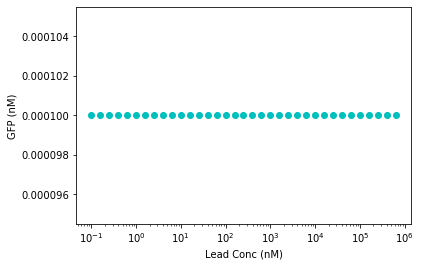

At translation rate  0.0001 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


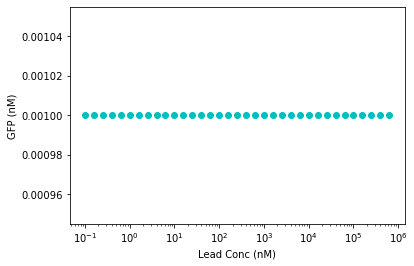

At translation rate  0.001 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


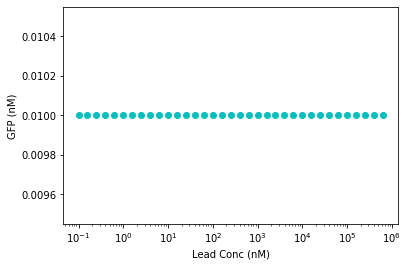

At translation rate  0.01 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


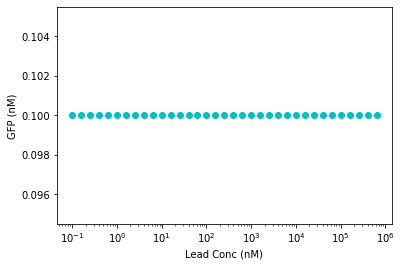

At translation rate  0.1 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


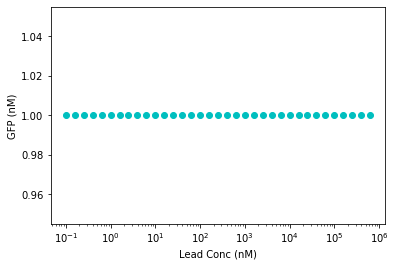

At translation rate  1 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


C:\Users\Shubhankar\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


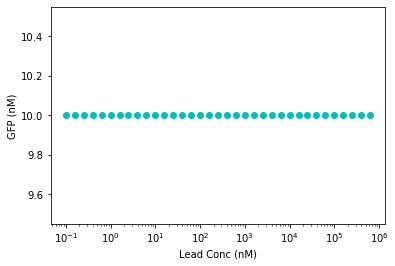

At translation rate  10 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


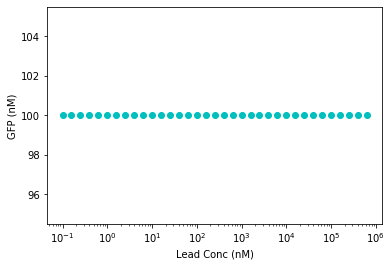

At translation rate  100 nM/min, Range of Lead concentration which can be detected is  [0.0, 0.001] μM


In [29]:
#Change the Lead concentration by 10^(0.2)~1.58, and check for at least linear increase in GFP Concentration

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
from scipy.integrate import solve_ivp
import math as mt

def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x / y

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
#vTL = 16.1       #Reporter translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244        #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

def model(z,t):
    
    #Initialize variables in a vector
    mR = z[0]         #repressor mRNA
    R = z[1]          #repressor monomer
    R2 = z[2]         #repressor dimer               #R2O - free operator of reporter gene
    Aout = z[3]
    A = z[4]          #analyte                       #R2A2 - repressor-operator complex
    O = z[5]          #inactive repressor
    mF = z[6]         #reporter mRNA
    Fin = z[7]        #inactive reporter
    F = z[8]          #reporter
    TLR = z[9]        #Translation resources
    TA = z[10]
    vTL = z[11]
    
    
    #ODEs  
    dmRdt = (vTX2*(GR**2)/((KTX2**2)+(GR**2))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (vTL*TLR*(mR**3)/((KTL2**3)+(mR**3)+(mF**3))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout)/2)      #Repressor dimer Conc               
    dAoutdt = -P*(Aout-A)
    dAdt = P*(Aout-A) - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout)/2)  #Analyte Conc
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**2)/((KTX1**2)+(O**2))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (vTL*TLR*(mF**3)/((KTL1**3)+(mF**3)+(mR**3))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    dTAdt = 0
    dvTLdt = 0
    
    return [dmRdt, dRdt, dR2dt, dAoutdt, dAdt, dOdt, dmFdt, dFindt, dFdt, dTLRdt, dTAdt, dvTLdt]


#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
TLR0 = 1520

O0 = 5
GR = O0

A0 = 0                 #Lead Concentration

TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<

t = np.linspace(0,300,100000)

AZ = []


def rang(v):
    
    GFP = []
    LD = []
    
    k = 0
    #For loop to find Range of detection (GFP Saturation)
    for i in range(-5,30):
        
        gfp = []
        Aout0 = 10**(i/5)            #10^(0.2) = 1.585, Expecting atleast a linear increase in fluoroscence
        TA = A0 + Aout0 + 2*R2A20
    
        z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]
    
        #y,az = odeint(model,z,t,args=(GR0,TO0,TA,v), full_output = True, atol = 1e-20, mxstep=5000000) #, hmax = ?? TRY Stuff....
        #AZ.append(az)
        
        ans = odeint(model, z, t)

        gfp = ans[8]       
        GFP.append(gfp[-1])
        LD.append(Aout0)
        
        l=0
        u=1
        
        k+=1

    
    n=0; m=0
    for n in range(1,k):
        #Check Lower Bound of Detection
        if safe_division(GFP[n],GFP[n-1]) > 1.5:
            #l.append(v)
            #l.append(GFP[i-1])
            #print(l)
            l = LD[n-1]
            break

    for m in range(1,k-1):
        #Check Upper Bound of Detection
        if safe_division(GFP[m],GFP[m-1]) > 1.5:
            #u.append(v)
            #u.append(GFP[i+1])
            #print(u)
            u = LD[m]
    
    r = [l*0.001, u*0.001]
    return r,GFP,LD


#print("Rate of translation, [Range of lead that can be measured by the biosensor in μM]")

for i in range(-4,3):
    v = 10**i
    z,G,L = rang(v)
    r = [v, z]
    g = []; l = []
    g[:] = [mt.floor(A*0.6022) for A in G]
    l[:] = [A*1e-3 for A in L]
    plt.plot(l, g, 'co')
    plt.xlabel("Lead Conc (μM)")
    plt.ylabel("GFP (# of molecules)")
    plt.xscale('log')
    plt.show()
    #R.append(r)
    print('At translation rate ',v,'nM/min, Range of Lead concentration which can be detected is ',z,'μM' )
    
    
#print([0.082, rang(0.082)])


## GRAPHS for above Biosensor model

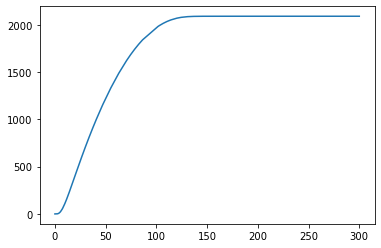

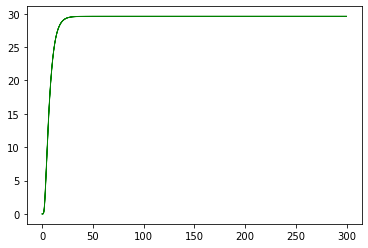

In [40]:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab as plot
from decimal import Decimal
from scipy.integrate import solve_ivp

#Initialize some constants
vTX1 = 18.2       #reporter transcription rate constant
vTX2 = 18.2       #repressor transcription rate constant
KTX1 = 8.5        #Michaelis-Menten constant for reporter transcription 
KTX2 = 8.5        #Michaelis-Menten constant for repressor transcription
lam_m1 = 0.08     #reporter mRNA degradation rate constant
lam_m2 = 0.08     #repressor mRNA degradation rate constant
vTL = 0.0082       #Reporter translation rate constant, 0.0076
KTL1 = 29.9       #Michaelis-Menten constant for translation of reporter
KTL2 = 29.9       #Michaelis-Menten constant for translation of repressor
vlamTLR = 13.5    #Translation resources degradation rate constant
KlamTLR = 53.2    #Michaelis-Menten constant for degradation of TL resources
kmat = 0.244        #reporter maturation rate constant
k2R = 50          #repressor dimerization rate constant
k_2R  = 0.001     #repressor dimer dissociation rate constant
kr = 960          #association rate constant for repression
k_r = 2.4         #dissociation rate constant for repression
kdr1 = 3.0e7      #association rate constant for first derepression mechanism 
k_dr1 = 12        #dissociation rate constant for first derepression mechanism
kdr2 = 3.0e7      #association rate constant for second derepression mechanism   
k_dr2 = 4800      #dissociation rate constant for second derepression mechanism
kleak = 0.0033    #leak reporter transcription rate constant
P = 7.4*1e-4      #Permeability, for now using P of Na+ ~ 7.4*1e-4 nm/s

def model(t,z):
    
    #Initialize variables in a vector
    mR = z[0]         #repressor mRNA
    R = z[1]          #repressor monomer
    R2 = z[2]         #repressor dimer               #R2O - free operator of reporter gene
    Aout = z[3]
    A = z[4]          #analyte                       #R2A2 - repressor-operator complex
    O = z[5]          #inactive repressor
    mF = z[6]         #reporter mRNA
    Fin = z[7]        #inactive reporter
    F = z[8]          #reporter
    TLR = z[9]        #Translation resources
    TA = z[10]
    vTL = z[11]
    
    
    #ODEs  
    dmRdt = (vTX2*(GR**2)/((KTX2**2)+(GR**2))) - lam_m2*mR                                       #Repressor mRNA Conc
    dRdt = (vTL*TLR*(mR**3)/((KTL2**3)+(mR**3)+(mF**3))) - 2*k2R*(R**2) + 2*k_2R*R2             #Repressor Conc  
    dR2dt = k2R*(R**2) - k_2R*R2 - kr*R2*O + k_r*(TO-O) - kdr1*(A**2)*R2 + k_dr1*((TA-A-Aout)/2)      #Repressor dimer Conc               
    dAoutdt = -P*(Aout-A)
    dAdt = P*(Aout-A) - 2*kdr1*(A**2)*R2 + 2*k_dr1*((TA-A-Aout)/2) - 2*kdr2*(A**2)*(TO-O) + 2*k_dr2*O*((TA-A-Aout)/2)  #Analyte Conc
    dOdt = -kr*R2*O + k_r*(TO-O) + kdr2*(A**2)*(TO-O) - k_dr2*O*((TA-A-Aout)/2)                       #Operator Conc
    dmFdt = (vTX1*(O**2)/((KTX1**2)+(O**2))) - lam_m1*mF + kleak*(TO-O)                          #Reporter mRNA Conc
    dFindt = (vTL*TLR*(mF**3)/((KTL1**3)+(mF**3)+(mR**3))) - kmat*Fin                           #Inactive Reporter Conc
    dFdt = kmat*Fin                                                                              #Active Reporter Conc  
    dTLRdt = -vlamTLR*TLR/((KlamTLR)+(TLR))                                                      #Translation Resources Conc
    dTAdt = 0
    dvTLdt = 0
    
    return [dmRdt, dRdt, dR2dt, dAoutdt, dAdt, dOdt, dmFdt, dFindt, dFdt, dTLRdt, dTAdt, dvTLdt]

#Initial Conditions, conc in nM
mR0 = 0
R0 = 0
R20 = 0
R21 = 300
R2O0 = 0
R2A20 = 0
mF0 = 0
Fin0 = 0
F0 = 0
TLR0 = 1520

O0 = 8
GR = O0

A0 = 0                 #Lead Concentration
Aout0 = 1e5

TO = O0 + R2O0        #LOOK AT THIS----------------------<<<<<<
TA = A0 + Aout0 + 2*R2A20

v = 0.082

z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]

ans = solve_ivp(fun=model, t_span=(0,300), y0=z, method = 'BDF')

#print(np.shape(y()))

a = ans['y'][8]
g = []
g[:] = [A*0.6022 for A in a]

plt.plot(ans['t'], g)
plt.show()


for i in range(1,60,5):
    
    Aout0 = i/10
    TA = A0 + Aout0 + 2*R2A20

    z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]
    ans = solve_ivp(fun=model, t_span=(0,300), y0=z, method = 'BDF')

    a = ans['y'][8]
    g = []
    g[:] = [A for A in a]

    plt.plot(ans['t'], g, 'g', linewidth = (i+1)/60)
    
plt.show()

#print(ans)

Translation Rate : 0.0001 nM/min


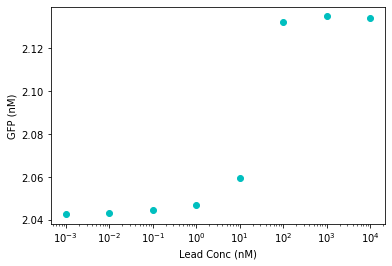

Translation Rate : 0.001 nM/min


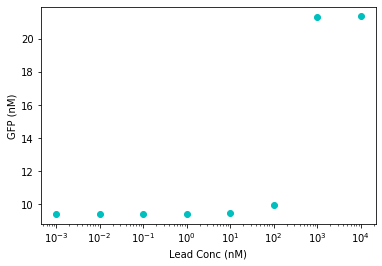

Translation Rate : 0.01 nM/min


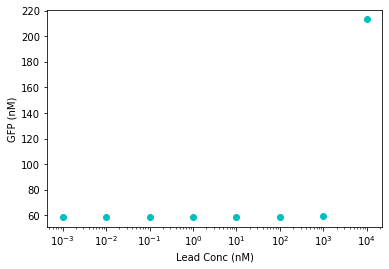

Translation Rate : 0.1 nM/min


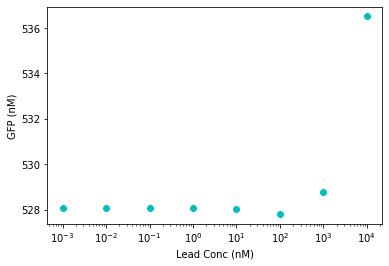

Translation Rate : 1 nM/min


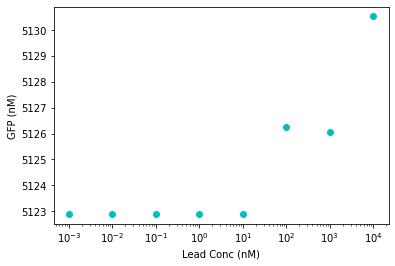

Translation Rate : 10 nM/min


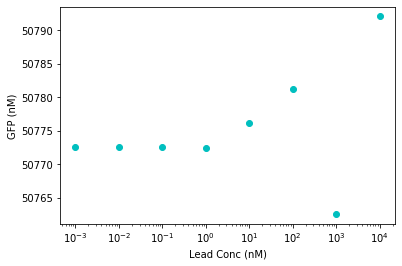

Translation Rate : 100 nM/min


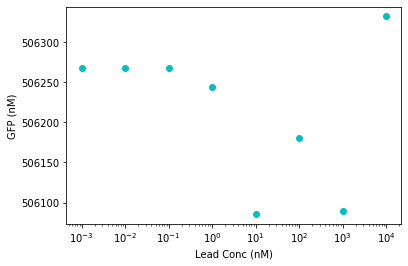

In [20]:

def grf_ld_gfp(v):
    
    G = []
    L = []
    
    for i in range(-3,5):
    
        Aout0 = 10**i
        TA = A0 + Aout0 + 2*R2A20
        z = [mR0,R0,R20,Aout0,A0,O0,mF0,Fin0,F0,TLR0,TA,v]
    
        ans = solve_ivp(fun=model1, t_span=(0,300), y0=z, method = 'BDF')
    
        gfp = ans['y'][8]
        G.append(gfp[-1])
        L.append(Aout0)
    
    print("Translation Rate :",v,"nM/min")
    plt.plot(L, G, 'co')
    plt.xlabel("Lead Conc (nM)")
    plt.ylabel("GFP (nM)")
    plt.xscale('log')
    plt.show()
    
for i in range(-4,3):
    v = 10**i
    z = grf_ld_gfp(v)